In [2]:
import torch
import numpy as np
from scipy.io.wavfile import read, write
from scipy import signal
import matplotlib.pyplot as plt
import seaborn as sns


from Model import Net
from boltzman_machine import RBM
from Dataloader import AudioDataset
from helpers import Reconstruct, Viz_Y


from torch.optim import LBFGS, Adam,SGD
from sklearn.decomposition import NMF
from sklearn.preprocessing import MinMaxScaler
import warnings 

warnings.simplefilter('ignore')

In [3]:
def gain_params(s1,s2,y):

        l2_s1 = torch.norm(s1.float(),2, None)
                 
        l2_s2 = torch.norm(s2.float(),2, None)
               
        l2_Y = torch.norm(y.float(),2, None)
              
        # u is initialized by the l2-norm of the initial NMF source estimate sˆ1 
        # divided by the l2-norm of the mixed signal y
        u = torch.div(l2_s1, l2_Y) 

        # v is initialized by the same manner
        v = torch.div(l2_s2, l2_Y)

        return u,v
    
def gain_params_vec(s1,s2,y):

        l2_s1 = torch.norm(s1.float().t(),2, True)
                 
        l2_s2 = torch.norm(s2.float().t(),2, True)
               
        l2_Y = torch.norm(y.float().t(),2, True)
              
        # u is initialized by the l2-norm of the initial NMF source estimate sˆ1 
        # divided by the l2-norm of the mixed signal y
        u = torch.div(l2_s1, l2_Y) 

        # v is initialized by the same manner
        v = torch.div(l2_s2, l2_Y)

        return u,v
    
    
def feed_(x):
    
    f = model(x)
    f1 = f[0] 
    f2 = f[1]
    return f1,f2

def energy_1(x_source1):
    
    f1,f2 = feed_(x_source1)
    e1 = (1 - f1 ).pow(2) + f2.pow(2)
    return e1 

def energy_2(x_source2):

    f1,f2 = feed_(x_source2)
    e2 = f1.pow(2) + (1 - f2 ).pow(2) 
    return e2

def E_err(s1,s2,y):
  
    u,v = gain_params_vec(s1,s2,y) 
    return torch.norm(torch.mul(u,s1) + torch.mul(v,s2) - y,'fro',None)

def E_err_vec(s1,s2,y,u,v):
  
    return torch.norm(u*s1 + v*s2 - y,'fro',None)


def relu(x):
    return torch.nn.ReLU()(x)

def nonnegative_constraint(s1,s2,y,u,v):  
    
    u_sum  = torch.sum(relu(u))
    v_sum  = torch.sum(relu(v))
    x1_sum = torch.sum(relu(s1))
    x2_sum = torch.sum(relu(s2))
    total_sum = 1 / (u_sum + v_sum + x1_sum + x2_sum)    #vector containing all the unknowns which must all be nonnegative

    return total_sum 


def nonneg_constraint(s1,s2,u,v):
    
    R=min([s1.min().item(),s2.min().item(),u,v,0])
    
    return R**2

In [ ]:
print(torch.cuda.is_available())

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

# 1.Read audio file:

In [30]:
samplerate, data = read("../data/mix_signal.wav")
music=data[:,0]
length=music.shape[0]/samplerate
print('Shape of the data {}'.format(music.shape[0]))
print('Length : {:.2f}s'.format(length))
print('Sample rate : {}'.format(samplerate))

Shape of the data 3276667
Length : 74.30s
Sample rate : 44100


# 2.Apply STFT :

## We can change :

* Window : Type of window
* nperseg : length of window
* noverlap : overlap between windows.
* nfft : fft length > window size


WINDOW_SIZE=480


In [42]:
WINDOW = 'hamming'
WINDOW_SIZE=128
OVERLAP = 0.6 * WINDOW_SIZE
NFFT=512
f,t,Y= signal.stft(music,samplerate,window=WINDOW,nperseg=WINDOW_SIZE,noverlap=OVERLAP,nfft=NFFT)
Yabs=np.abs(Y)

In [ ]:
Viz_Y(Yabs,t ,f)

# 3.Apply NMF :

In [46]:
n_components=2
scaler = MinMaxScaler()
#Yabs = scaler.fit_transform(Yabs)
Yabs[Yabs==0]=0.001
scaler
model = NMF(n_components=n_components, init='random',alpha=0.9,beta_loss='itakura-saito',solver="mu",max_iter=500, random_state=0)
B = model.fit_transform(Yabs)
G = model.components_

Sources = Reconstruct(n_components, B, G, Y)
s1 = torch.tensor(Sources[0], dtype = torch.double)
s2 = torch.tensor(Sources[1])
Yabs = torch.tensor(Yabs)
u0,v0 = gain_params_vec(s1, s2, Yabs)

Source shape = (257, 63014)


In [33]:
Yabs

tensor([[1.2858e-01, 6.8733e-01, 6.3910e-01,  ..., 1.0000e-03, 1.0000e-03,
         1.0000e-03],
        [1.5564e-01, 5.2962e-01, 1.5653e+00,  ..., 1.0000e-03, 1.0000e-03,
         1.0000e-03],
        [1.5994e-01, 6.4995e-01, 1.6076e+00,  ..., 1.0000e-03, 1.0000e-03,
         1.0000e-03],
        ...,
        [1.4272e-02, 7.5180e-03, 1.3370e-02,  ..., 1.0000e-03, 1.0000e-03,
         1.0000e-03],
        [1.5146e-02, 7.3850e-03, 5.2636e-03,  ..., 1.0000e-03, 1.0000e-03,
         1.0000e-03],
        [2.2361e-02, 2.1123e-02, 7.7994e-03,  ..., 1.0000e-03, 1.0000e-03,
         1.0000e-03]])

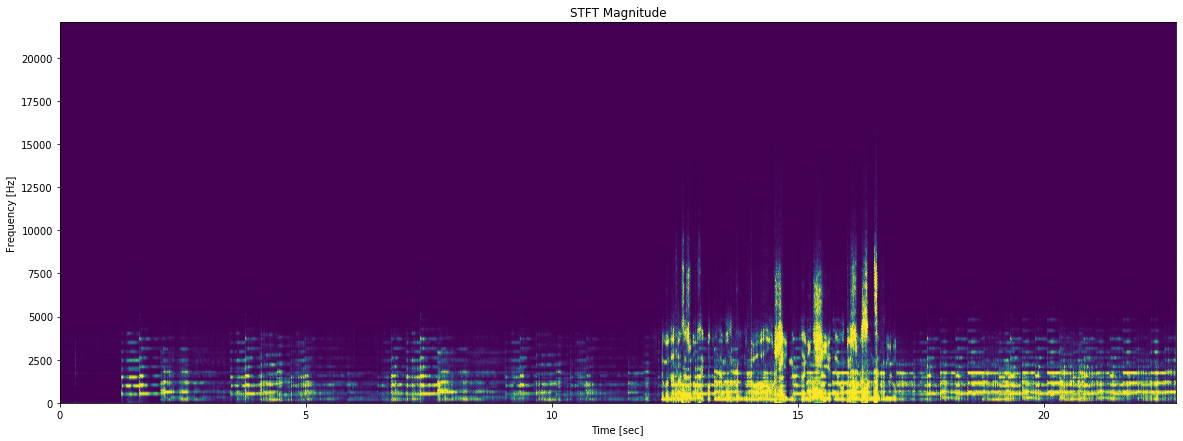

In [8]:
Viz_Y(s1,t ,f,vmax=0.1)

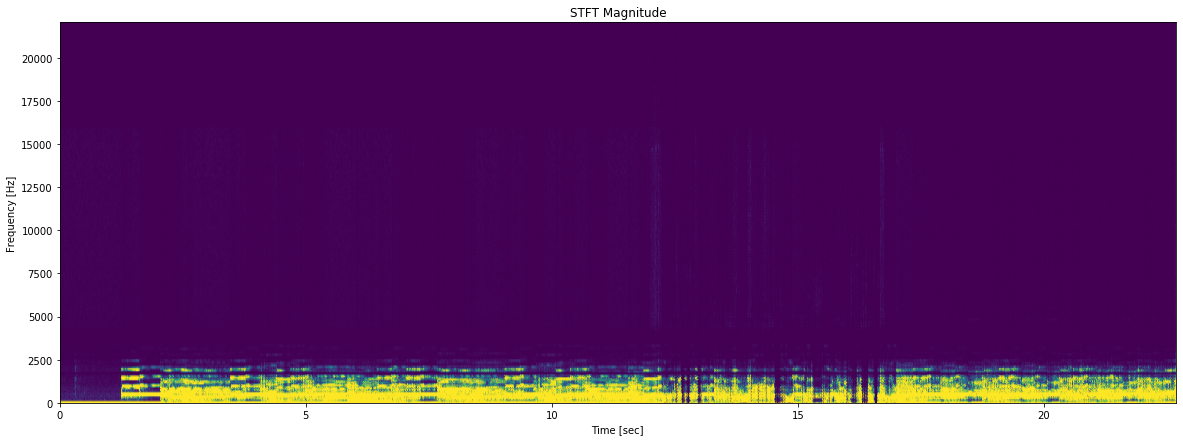

In [7]:
Viz_Y(s2,t ,f,vmax=0.1)

In [34]:
s1

tensor([[-8.3178e-03, -5.5813e-02,  2.0549e-02,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        [-1.3275e-03,  4.6281e-02, -5.0401e-02,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        [ 1.3384e-02,  6.6537e-02,  4.2035e-02,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        ...,
        [-3.1177e-05,  2.7706e-06,  1.2563e-05,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        [ 3.0328e-05, -1.8981e-05,  4.1126e-06,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        [-4.2507e-05,  5.2240e-05, -7.3381e-06,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00]], dtype=torch.float64)

In [44]:
 _, xrec =  signal.istft(s1,
                          samplerate,
                          window = WINDOW,
                          nperseg=WINDOW_SIZE,
                          noverlap=OVERLAP,
                          nfft = NFFT)
write("../../s1.wav", samplerate, xrec.astype(np.int16))

In [45]:
 _, xrec =  signal.istft(s2,
                          samplerate,
                          window = WINDOW,
                          nperseg=WINDOW_SIZE,
                          noverlap=OVERLAP,
                          nfft = NFFT)
write("../../s2.wav", samplerate, xrec.astype(np.int16))

# 4. Visualize initial distribution of Y and (u * s1+v * s2) :

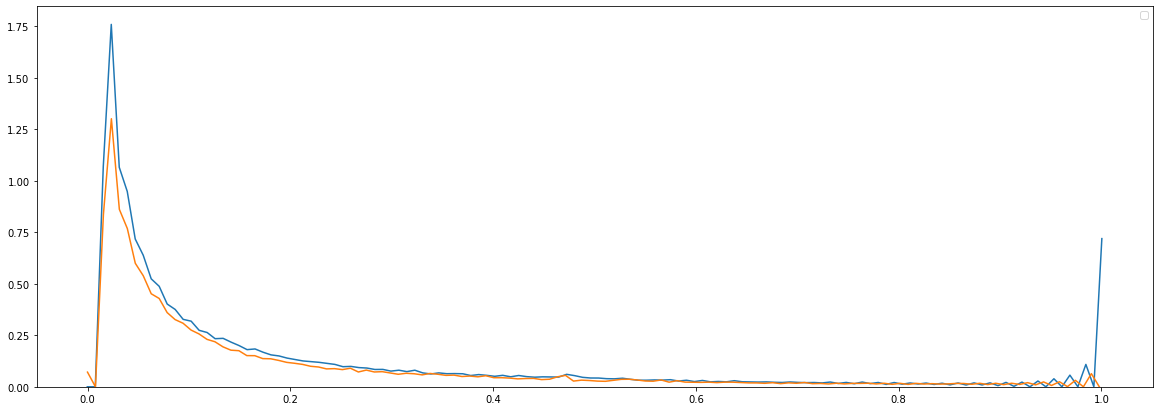

In [9]:
fig,ax=plt.subplots(1,1,figsize=(20,7))
g = sns.distplot(Yabs.detach().numpy(),hist=False,ax=ax)
g = sns.distplot((u0*s1+v0*s2).detach().numpy(), hist = False,ax=ax)
ax.legend(['Yabs','reconstruction'])

In [10]:
L2_LOSS=torch.norm(u0*s1 + v0*s2 - Yabs,'fro',None)
print('Initial Loss = {}'.format(L2_LOSS))

Initial Loss = 35.425393548037924


 # Learning Loop :

* Define optimizer with all parameters W , x1 , x2 , u , v
* Dataloader gives a batch that we loop accross
* For each sample we feed the network with X1 and then we get f1 
* We feed with X2 and we get f2
* We compute u and v using the function.
* We compute the total loss.
* Loss.back()
* Optimizer step 

# 5.Train the DNN :

## 5.1.Compute the initial  estimates of u and v : y = u * s1 + v * s2

In [ ]:
s1 = torch.tensor(Sources[0])
s2 = torch.tensor(Sources[1])
Yabs = torch.tensor(Yabs)
u,v = gain_params_vec(s1, s2, Yabs)

## 5.2.Set the require grads to true:


In [ ]:
s1.requires_grad = True
s2.requires_grad = True
u.requires_grad = True
v.requires_grad = True
Yabs.requires_grad = False

## 5.3.Instantiation of the model with pretrained wheights of RBM:

In [ ]:
model = Net(257)

model_1 = RBM(257,100)
model_1.load_state_dict(torch.load("../RBM/pretraining/w_layer_1"))
model_2 = RBM(100,50)
model_2.load_state_dict(torch.load("../RBM/pretraining/w_layer_2"))
model_3 = RBM(50,200)
model_3.load_state_dict(torch.load("../RBM/pretraining/w_layer_3"))


with torch.no_grad():
    model.fc1.weight = model_1.feed.weight
    model.fc2.weight = model_2.feed.weight
    model.fc3.weight = model_3.feed.weight
print(model)


## 5.4. Define loss function :

$$E_{1}(\boldsymbol{x})=\left(1-f_{1}(\boldsymbol{x})\right)^{2}+\left(f_{2}(\boldsymbol{x})\right)^{2}$$ \\
$$E_{2}(\boldsymbol{x})=\left(f_{1}(\boldsymbol{x})\right)^{2}+\left(1-f_{2}(\boldsymbol{x})\right)^{2}$$


$$E_{e r r}\left(\boldsymbol{x}_{1}, \boldsymbol{x}_{2}, \boldsymbol{y}, u, v\right)=\left\|u \boldsymbol{x}_{1}+v \boldsymbol{x}_{2}-\boldsymbol{y}\right\|^{2}$$

Let's consider $\boldsymbol{\theta}=\left(\boldsymbol{x}_{1}, \boldsymbol{x}_{2}, u, v\right)=\left[\theta_{1}, \theta_{2}, \ldots, \theta_{n}\right]$  a vector containing all the unknowns which must all be nonnegative.

$$R(\theta)=(\min (\theta, 0))^{2}$$

$$\begin{aligned} E\left(\boldsymbol{x}_{1}, \boldsymbol{x}_{2}, \boldsymbol{y}, u, v\right) &=E_{1}\left(\boldsymbol{x}_{1}\right)+E_{2}\left(\boldsymbol{x}_{2}\right)+\lambda E_{e r r}\left(\boldsymbol{x}_{1}, \boldsymbol{x}_{2}, \boldsymbol{y}, u, v\right)  + \beta \sum_{i} R\left(\theta_{i}\right) \end{aligned}$$

In [ ]:
def Criteria(s1,s2,Yabs,u,v,i) :
    
    # Feed forward and get energy 1 and 2
    e1 = energy_1(s1[:,i].float())
    e2 = energy_2(s2[:,i].float())
    
    # Get least square error :
    e_rr=E_err_vec(s1[:,i], s2[:,i], Yabs[:,i],u[i],v[i])
    
    # Non negative constraint
    R = nonneg_constraint(s1[:,i], s2[:,i], u[i], v[i])
    
    # Compute total Loss :
    
    return e1 + e2 + e_rr + R
    

## 5.5 LBFGS code (slow):

params = list(model.parameters())+[s1]+[s2]+[u]+[v] 
optimizer= LBFGS(params, lr=0.1, max_iter=20, tolerance_grad=1e-07)
model.train()
for i in range(s1.shape[1]):
    
    def closure():
        optimizer.zero_grad()
        loss = Criteria(s1,s2,Yabs,u,v,i)
        loss.backward()
        return loss
        
        
    print('step i= {}'.format(i))
    optimizer.step(closure)

## 5.6. Define optimizer and the parameters to optimize : s1 s2 u v and network parameters:

In [ ]:
params = list(model.parameters())+[s1]+[s2]+[u]+[v] 
optimizer= SGD(params, lr=0.001)

## 5.7.Train the model:

In [ ]:
model.train()
N_epochs = 10
for e in range(N_epochs):
    
    loss_e=0.0
    for i in range(s1.shape[1]):

            optimizer.zero_grad()
            loss = Criteria(s1,s2,Yabs,u,v,i)
            loss.backward()
            # fill zeros into the first row of grad
            u.grad.data[:i].fill_(0)
            u.grad.data[i+1:].fill_(0)
            
            v.grad.data[:i].fill_(0)
            v.grad.data[i+1:].fill_(0)
            s1.grad.data[:,:i].fill_(0)
            s1.grad.data[:,i+1:].fill_(0)
            s2.grad.data[:,:i].fill_(0)
            s2.grad.data[:,i+1:].fill_(0)



            optimizer.step()
            loss_e+=loss
            
    print('Epoch {} , Loss = {:.2f}'.format(e,loss_e/s1.shape[1]))

# 6.Check the results:

## 6.1.Check that all values are positive:

In [ ]:
print('Min of s1 {:.4f}'.format(s1.min()))
print('Min of s2 {:.4f}'.format(s2.min()))
print('Min of U {:.4f}'.format(u.min()))
print('Min of V {:.4f}'.format(v.min()))

## 6.2.Check the distribution :

In [ ]:
plt.figure(figsize=(20,7))
sns.distplot(Yabs.detach().numpy(),hist=False)
sns.distplot((u*s1+v*s2).detach().numpy(), hist = False)

## 6.3. Check the L2 loss:

In [ ]:
print('L2 loss = {}'.format(torch.norm(u*s1 + v*s2 - Yabs,'fro',None)))